In [1]:
!pip install pytesseract



In [2]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## TF_OD installation

In [3]:
# Clone the tensorflow models repository from GitHub
!git clone --depth 1 https://github.com/tensorflow/models


Cloning into 'models'...
remote: Enumerating objects: 3916, done.
remote: Counting objects: 100% (3916/3916), done.
remote: Compressing objects: 100% (3024/3024), done.
remote: Total 3916 (delta 1130), reused 1815 (delta 839), pack-reused 0
Receiving objects: 100% (3916/3916), 49.65 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (1130/1130), done.


In [4]:
#Copy the file
%%bash
cd /content/models/research
protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .

In [5]:
# Modify setup.py file to install the tf-models-official repository targeted at TF v2.8.0
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [6]:
# Install the Object Detection API
!pip install /content/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.10 (as of 10/03/22)
!pip install tensorflow==2.8.0


Processing ./models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 43.8 MB/s et

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 33.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.1
    Uninstalling tensorflow-2.8.1:
      Successfully uninstalled tensorflow-2.8.1


In [7]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10u

In [8]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [9]:
!cp '/content/drive/MyDrive/Object Detection/images2.zip'/content


cp: missing destination file operand after '/content/drive/MyDrive/Object Detection/images2.zip/content'
Try 'cp --help' for more information.


In [10]:
!mkdir /content/images
!unzip '/content/drive/MyDrive/Object Detection/images2.zip' -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test


Archive:  /content/drive/MyDrive/Object Detection/images2.zip
  inflating: /content/images/all/train/00306.jpg  
  inflating: /content/images/all/train/00306.xml  
  inflating: /content/images/all/train/00325.jpg  
  inflating: /content/images/all/train/00325.xml  
  inflating: /content/images/all/train/00326.jpg  
  inflating: /content/images/all/train/00326.xml  
  inflating: /content/images/all/train/00350.jpg  
  inflating: /content/images/all/train/00350.xml  
  inflating: /content/images/all/train/00353.jpg  
  inflating: /content/images/all/train/00353.xml  
  inflating: /content/images/all/train/00360.jpg  
  inflating: /content/images/all/train/00360.xml  
  inflating: /content/images/all/train/00365.jpg  
  inflating: /content/images/all/train/00365.xml  
  inflating: /content/images/all/train/00369.jpg  
  inflating: /content/images/all/train/00369.xml  
  inflating: /content/images/all/train/00370.jpg  
  inflating: /content/images/all/train/00370.xml  
  inflating: /conten

## Split folder (Train (80%), Validation(10%), Test(10%)

In [11]:
!wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/train_val_test_split.py
!python train_val_test_split.py

--2023-07-01 04:47:36--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/train_val_test_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [text/plain]
Saving to: ‘train_val_test_split.py’

train_val_test_spli 100%[===================>]   2.74K  --.-KB/s    in 0s      

2023-07-01 04:47:36 (49.4 MB/s) - ‘train_val_test_split.py’ saved [2803/2803]

Total images: 843
Images moving to train: 674
Images moving to validation: 84
Images moving to test: 85
Traceback (most recent call last):
  File "/content/train_val_test_split.py", line 49, in <module>
    os.rename(os.path.join(parent_path,xml_fn),os.path.join(train_path,xml_fn))
FileNotFoundError: [Errno 2] No su

## Create Label Records and TFRecords

In [12]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
car
truck
bus
bicycle
motorbike
trishaw
three-wheeler
person
road-sign
traffic light
EOF


In [13]:
# Download data conversion scripts
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py


--2023-07-01 04:47:50--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1348 (1.3K) [text/plain]
Saving to: ‘create_csv.py’

create_csv.py       100%[===================>]   1.32K  --.-KB/s    in 0s      

2023-07-01 04:47:50 (66.2 MB/s) - ‘create_csv.py’ saved [1348/1348]

--2023-07-01 04:47:50--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githu

In [14]:
# Create CSV data files and TFRecord files
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord


Successfully converted xml to csv.
Successfully converted xml to csv.
2023-07-01 04:48:07.342865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-07-01 04:48:07.342938: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Traceback (most recent call last):
  File "/content/create_tfrecord.py", line 120, in <module>
    tf.app.run()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/platform/app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in 

In [15]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'


## Setting up Model(References from Tensorflow model zoo)

In [16]:
# Change the chosen_model variable to deploy different models available in the TF2 object detection zoo
chosen_model = 'ssd-mobilenet-v2-fpnlite-320'

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
}



In [17]:
model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']


In [18]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Download pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download training configuration file for model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}



/content/models/mymodel
--2023-07-01 04:48:34--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M   122MB/s    in 0.2s    

2023-07-01 04:48:34 (122 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

--2023-07-01 04:48:34--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 18

In [19]:
#num_step =total amount of steps to use for training the model
#batch_size = number of images to use per training step

# Set training parameters for the model
num_steps = 10000

if chosen_model == 'efficientdet-d0':
  batch_size = 4
else:
  batch_size = 25


In [20]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)


Total classes: 10


In [21]:
# Create custom configuration file by writing the dataset, model checkpoint, and training parameters into the base pipeline file
import re

%cd /content/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:

    # Set fine_tune_checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set tfrecord files for train and test datasets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # Set label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    # Change fine-tune checkpoint type from "classification" to "detection"
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)

    # If using ssd-mobilenet-v2, reduce learning rate (because it's too high in the default config file)
    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)

      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)

    # If using efficientdet-d0, use fixed_shape_resizer instead of keep_aspect_ratio_resizer (because it isn't supported by TFLite)
    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)


/content/models/mymodel
writing custom configuration file


In [22]:
# Set the path to the custom config file and the directory to store training checkpoints in
pipeline_file = '/content/models/mymodel/pipeline_file.config'
model_dir = '/content/training/'


## Train Custom TF_OD model

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir '/content/training/train'

In [ ]:
# Run training!
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1


/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10u

## Convert Model to TF lite model:

In [1]:
# Make a directory to store the trained TFLite model
!mkdir /content/custom_model_lite
output_directory = '/content/custom_model_lite'

# Path to training directory (the conversion script automatically chooses the highest checkpoint file)
last_model_path = '/content/training'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}


python3: can't open file '/content/models/research/object_detection/export_tflite_graph_tf2.py': [Errno 2] No such file or directory


In [ ]:
# Convert exported graph file into TFLite model file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect.tflite', 'wb') as f:
  f.write(tflite_model)

## Test TFlite model and calculate mAP

In [ ]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

      # Save detection results in .txt files (for calculating mAP)
      elif txt_only == True:

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

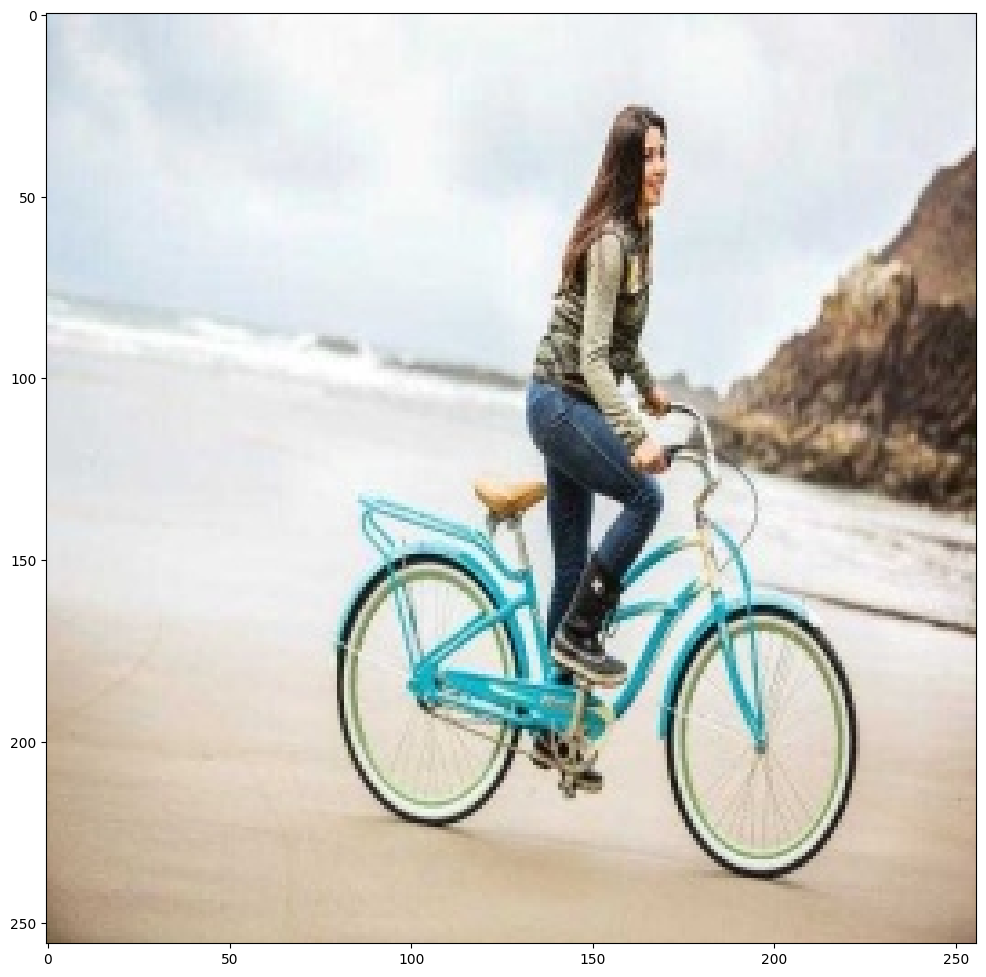

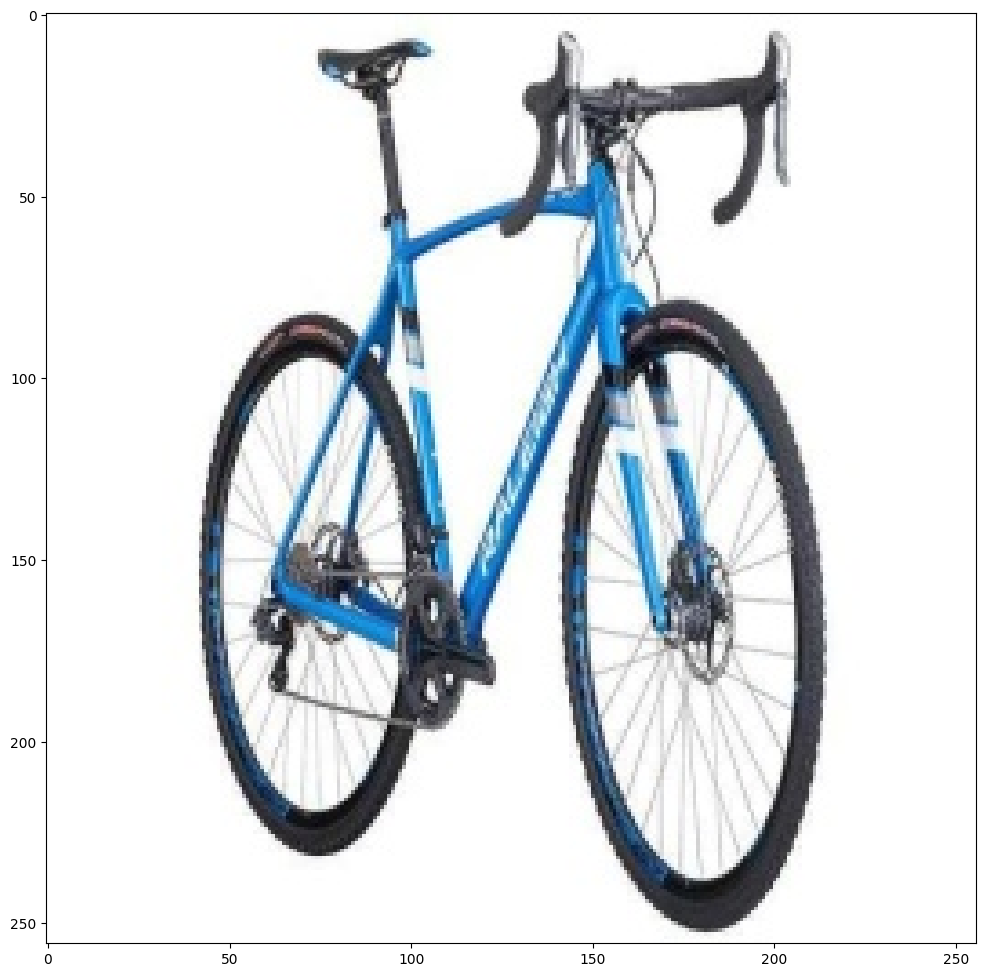

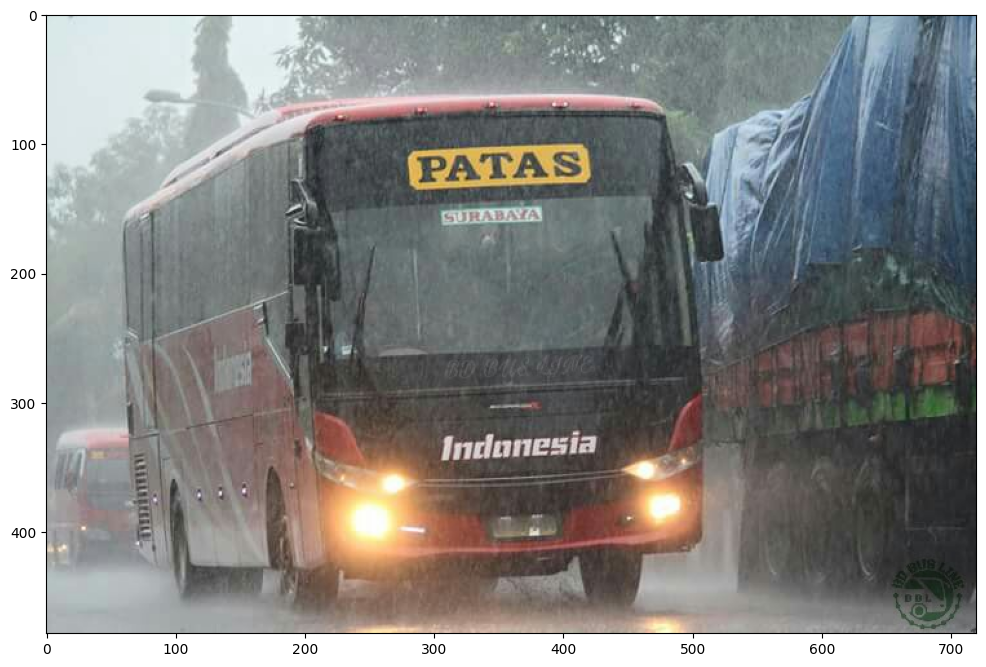

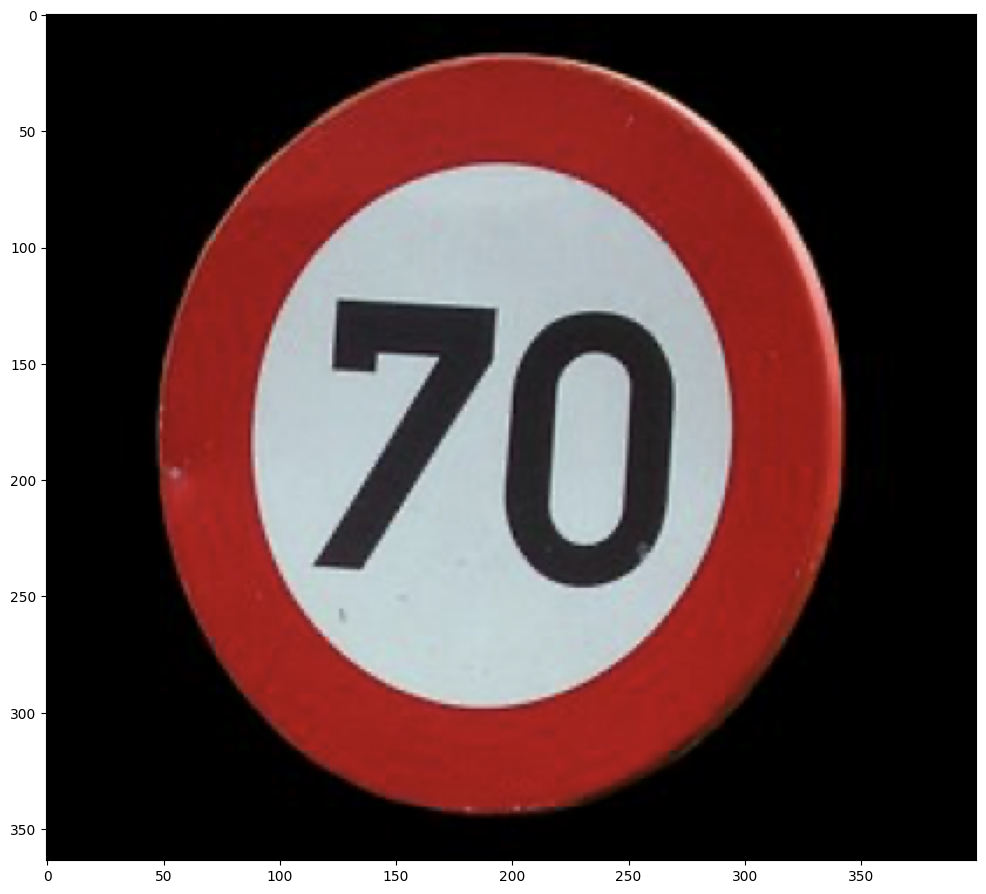

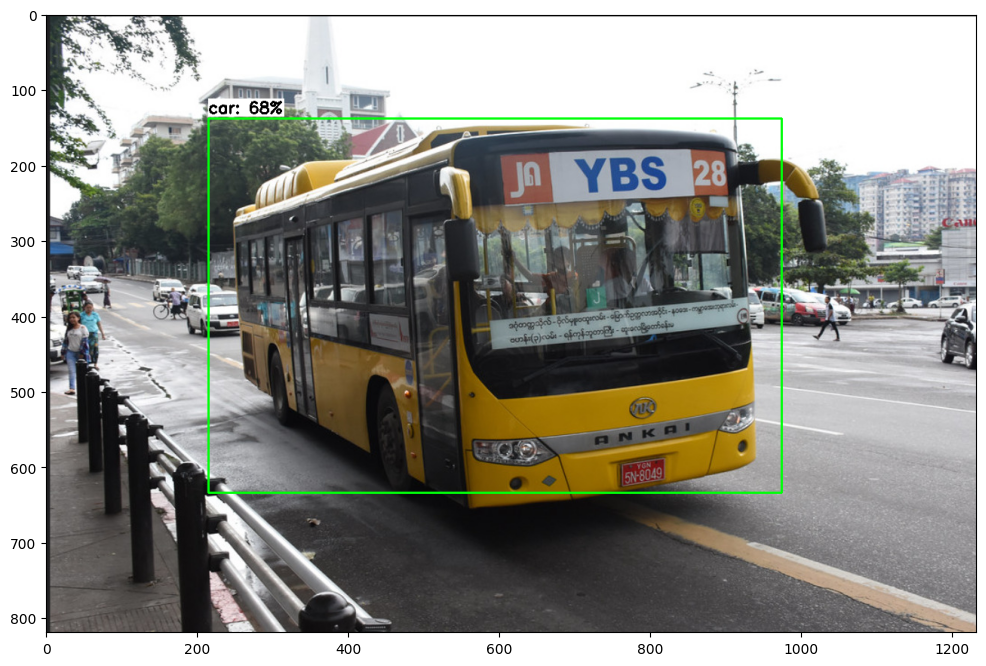

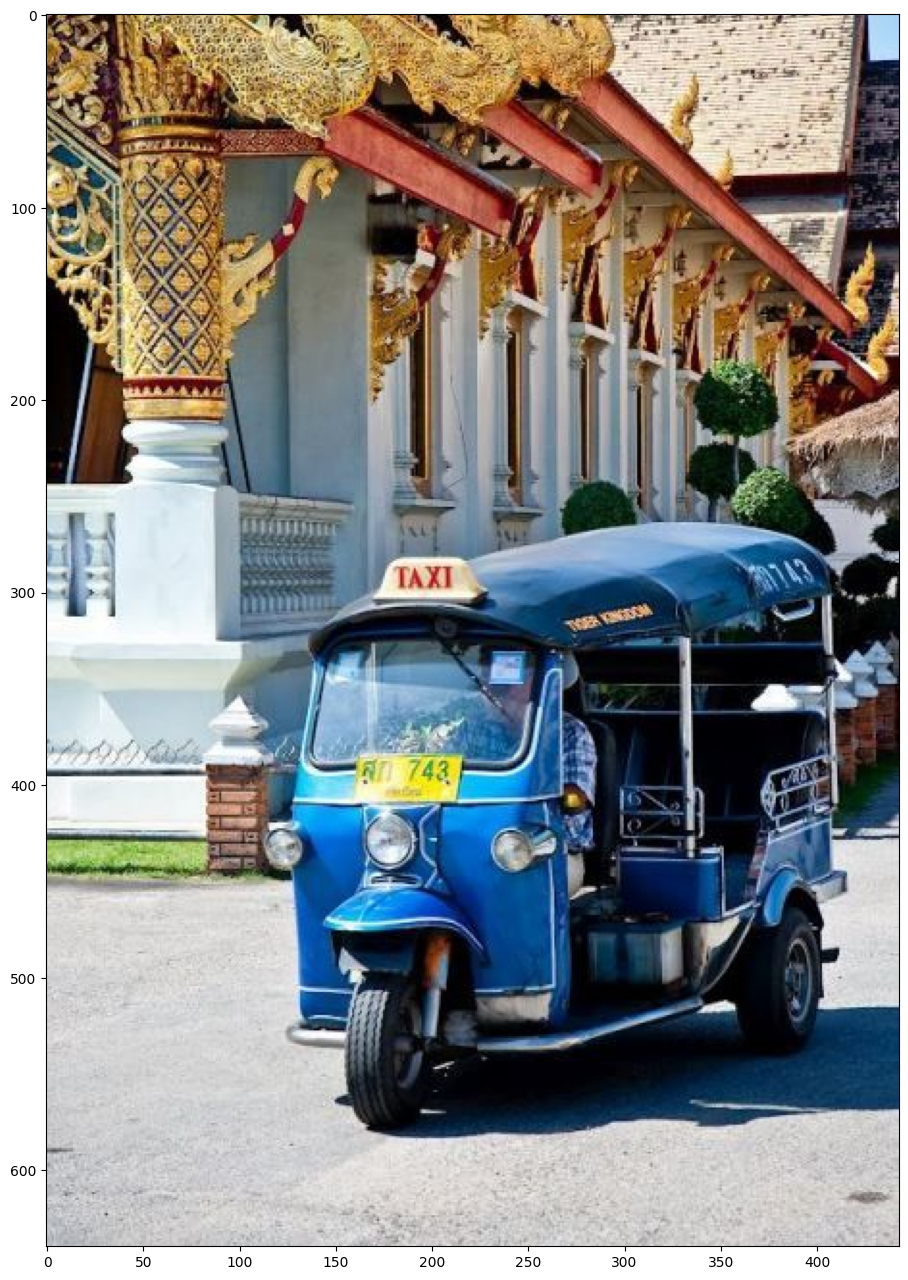

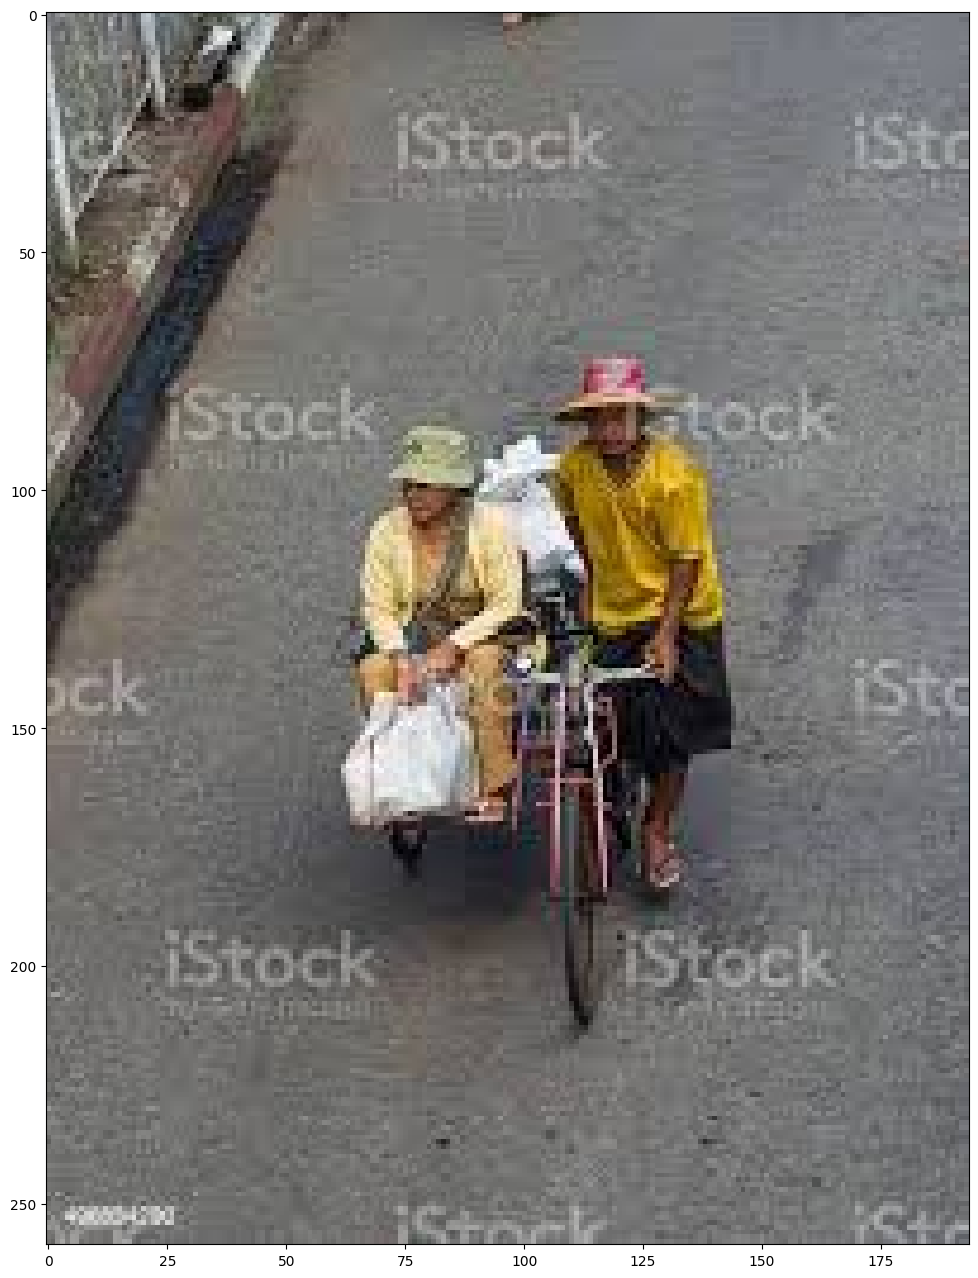

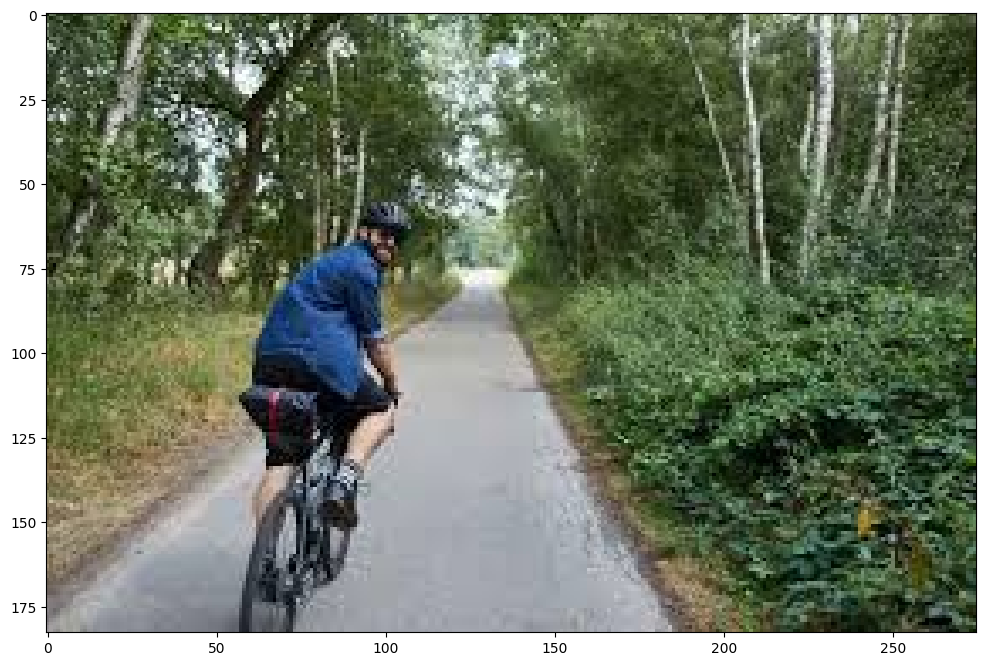

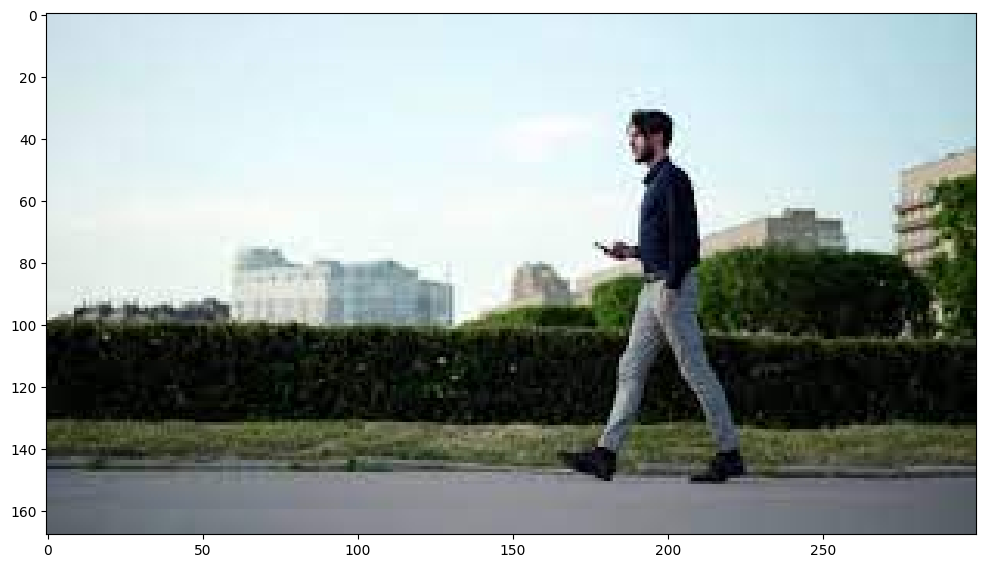

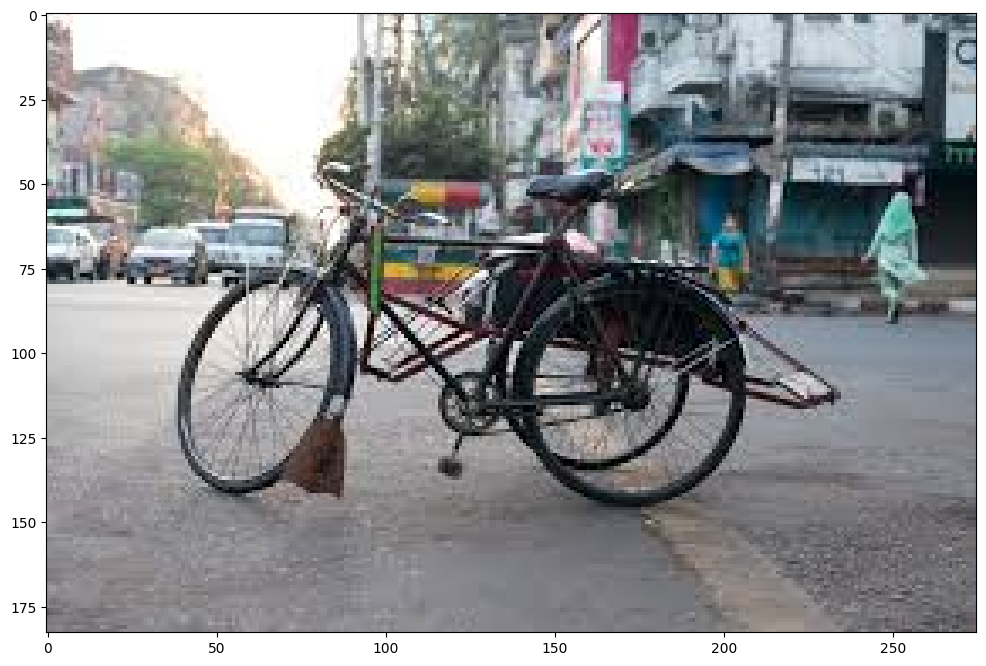

In [ ]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/drive/MyDrive/Object Detection/test'   # Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.01   # Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   # Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)